## Происходит считывание данных с файла и их визуализация

In [1]:
# Рисовать графики сразу 
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

# необходимые либы 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import time
from tqdm import tqdm
# Для виджетов 
from IPython.display import display, clear_output
from ipywidgets import DatePicker, Checkbox, ToggleButton, HBox

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from statsmodels.sandbox.regression.predstd import wls_prediction_std

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

### 1. Считываем данные генерации и потребления за год

In [2]:
from e_use_data import E_USE_DATA_URAL as df
df

,POWER_SYS_ID,E_USE_FACT
DATE_TIME,,
2014-01-01 00:00:00,630000,28550.0
2014-01-01 01:00:00,630000,28477.0
2014-01-01 02:00:00,630000,28046.0
2014-01-01 03:00:00,630000,27960.0
2014-01-01 04:00:00,630000,27973.0
...,...,...
2020-11-27 19:00:00,630000,31214.0
2020-11-27 20:00:00,630000,30746.0
2020-11-27 21:00:00,630000,30360.0


### 2. Фильтрация данных
#### 2.1 Дата

In [3]:
# Определяем от и до 
date_from = dt.datetime(2016, 1, 1, 0, 0)
date_to = dt.datetime(2019, 12, 31, 0, 0)

dpicker_from = DatePicker(
    description='От:',
    value = date_from
)
dpicker_to = DatePicker(
    description='До:',
    value=date_to
)

def time_2_datetime(t):
    return dt.datetime.combine(t, dt.datetime.min.time())

def on_from_button_clicked(b):
    global date_from
    date_from = time_2_datetime(b['new'])

def on_to_button_clicked(b):
    global date_to
    date_to = time_2_datetime(b['new'])

dpicker_from.observe(on_from_button_clicked, names='value')
dpicker_to.observe(on_to_button_clicked, names='value')

HBox([dpicker_from, dpicker_to])


#### 2.2 Ценовая зона

In [4]:
# first_zone = True 
# second_zone = True 

# first_cb = Checkbox(
#     description="1 ценовая зона",
#     value=first_zone)

# second_cb = Checkbox(
#     description="2 ценовая зона",
#     value=second_zone)

# def on_first_clicked(cb):
#     global first_zone
#     first_zone = cb.new
#     print("First zone ", first_zone)
    
# def on_second_clicked(cb): 
#     global second_zone
#     second_zone = cb.new
#     print("Second zone ", second_zone)
    
# first_cb.observe(on_first_clicked, names='value')
# second_cb.observe(on_second_clicked, names='value')

# HBox([first_cb, second_cb])


#### 2.3 Объединенные энергосистемы

In [5]:
# sys_list = df['POWER_SYS_ID'].unique()

# # инициализируем выбранные 
# sys_checked = dict((sys, True) for sys in sys_list)

# # создаём кнопочки 
# sys_cbs = [] 
# for sys in sys_list: 
#     def handler(local_sys): 
#         def wrap(cb):
#             global sys_checked
#             sys_checked[local_sys] = cb.new 
#             print(f"ОЭС {local_sys} {cb.new}")
#         return wrap
    
#     cb = Checkbox(
#         description=str(sys),
#         value = sys_checked[sys],
#         )
#     cb.observe(handler(sys), names='value')
#     sys_cbs.append(cb)
    
# HBox(sys_cbs)

#### 2.4 Выбираем графики 

In [6]:
# Список графиков 
# graphs = ('E_USE_FACT','E_USE_PLAN', 'GEN_FACT', 'GEN_PLAN')
graphs = ('E_USE_FACT',)
# инициализируем выбранные графики 
graph_checked = dict((gr, True) for gr in graphs)

# создаём кнопочки 
graph_cbs = [] 
for graph in graphs: 
    def handler(local_graph): 
        def wrap(cb):
            global graph_checked
            graph_checked[local_graph] = cb.new 
            print(f"График {local_graph} {cb.new}")
        return wrap
    
    cb = Checkbox(
        description=str(graph),
        value = graph_checked[graph],
        )
    cb.observe(handler(graph), names='value')
    graph_cbs.append(cb)
    
HBox(graph_cbs)

### 3. Графики по заданному диапазону

ToggleButton(value=False, description='Show')

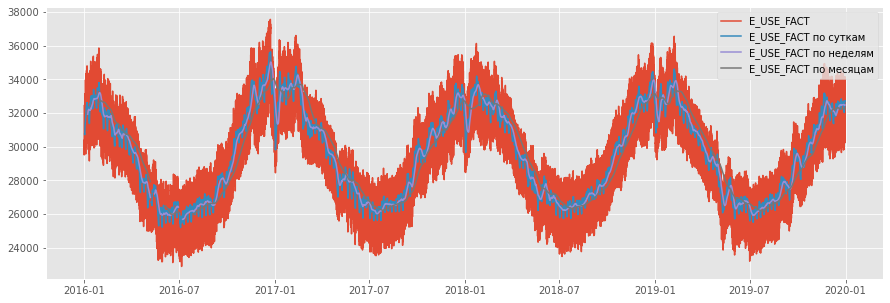

In [7]:
from data_pre_proc import running_mean, filter_by_date



# # фильтруем по зонам 
# def filter_by_zones(data_frame): 
#     global first_zone, second_zone
    
#     zone_filter = np.zeros(data_frame.shape[0], dtype=bool)
#     for zone_checked, zone_value in [(first_zone, 1), (second_zone, 2)]:
#         if zone_checked:
#             zone_filter |= (data_frame['PRICE_ZONE_ID'] == zone_value)
#     return zone_filter

# # фильтруем по ОЭС
# def filter_by_sys(data_frame):
#     global sys_checked

#     sys_filter = np.zeros(data_frame.shape[0], dtype=bool)
#     for sys, checked in sys_checked.items():
#         if checked: 
#             sys_filter |= (data_frame["POWER_SYS_ID"] == sys)
#     return sys_filter 


tb = ToggleButton(
    value=False,
    description='Show'
    )

def on_show(state):
    global df 
    global graphs, graph_checked
    
    global date_from, date_to
    
    # очищаем экран 
    clear_output(wait=True)
    display(tb)
    # фильтруем данные 
    filtered = df[filter_by_date(df, date_from, date_to)
#                   & filter_by_zones(df)
#                   & filter_by_sys(df)
                 ]
    
    # выводим на экран
#     for sys_key in filtered['POWER_SYS_ID'].unique():
#         sys_df = filtered[filtered['POWER_SYS_ID'] == sys_key]
    sys_df = filtered
#     power_key = 'E_USE_FACT'
    for power_key in graphs:
#         if graph_checked[power_key]:
        plt.plot(sys_df[power_key], label='{0}'.format(power_key))
        plt.plot(sys_df.index, sys_df[power_key].rolling(window=24).mean(), label='{0} по суткам'.format(power_key))
        plt.plot(sys_df.index, sys_df[power_key].rolling(window=24 * 7).mean(), label='{0} по неделям'.format(power_key))
        plt.plot(sys_df.index, sys_df[power_key].rolling(window=24 * 7 * 4).mean(), label='{0} по месяцам'.format(power_key))        
    plt.legend()
tb.observe(on_show, names='value')
on_show({})



### 4. Выделение остатка (исходные данные без тренда)

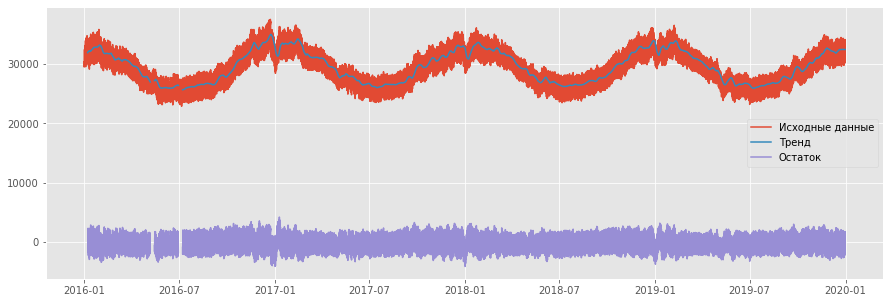

In [8]:
filtered = df[filter_by_date(df, date_from, date_to)]
# Исходные данные
df_init = filtered[['E_USE_FACT']]
# Тренд
df_trend = df_init.copy()
df_trend['E_USE_FACT'] = df_init['E_USE_FACT'].rolling(window=24 * 7).mean()
# Данные без тренда (остаток)
df_noise = df_init.copy()
df_noise['E_USE_FACT'] = df_init['E_USE_FACT'] - df_trend['E_USE_FACT']

plt.plot(df_init.index, df_init['E_USE_FACT'], label='Исходные данные')
plt.plot(df_trend.index, df_trend['E_USE_FACT'], label='Тренд')
plt.plot(df_noise.index, df_noise['E_USE_FACT'], label='Остаток')
plt.legend()

#### Вывод трендов за разные годы

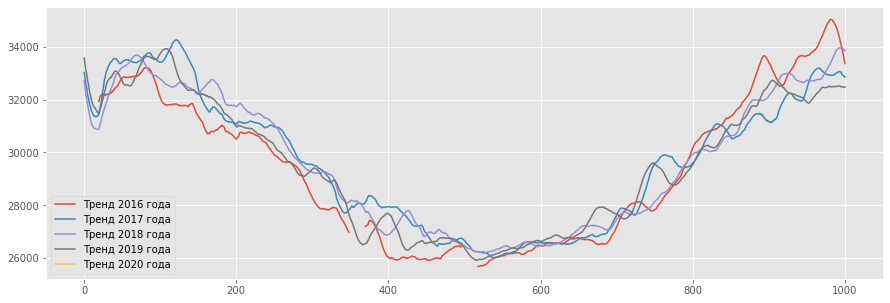

In [9]:
# Функция выделения кусков по годам
def filter_by_year(data_frame, year):
    start = dt.datetime(year, 1, 1, 0, 0)
    finish = dt.datetime(year, 12, 31, 0, 0)
    return (start <= data_frame.index) & (data_frame.index <= finish)
# Вывод трендов по годам (для демонстрации)
for year in range(2016, 2021):
    df_year = df_trend[filter_by_year(df_trend, year)]
    plt.plot(np.linspace(0, 1000, len(df_year)), df_year['E_USE_FACT'], label='Тренд {0} года'.format(year))
plt.legend()

### 5. Расчёт трендов промышленного производства

#### Подготовка данных

In [10]:
# Загрузка данных по промышленному производству
from industry_volume_data import URAL_SYS_INDUSTRY_VOLUME as ural_industry
# Разделим для удобства
ural_mineral = ural_industry[['MINERAL']]
ural_process = ural_industry[['PROCESS']]
ural_utilites = ural_industry[['UTILITIES']]
# Суммирование значений по месяцам
df_trend['YEAR_MONTH'] = df_trend.index.map(lambda x: dt.date(x.year, x.month, 1))
df_trend_month = df_trend.groupby('YEAR_MONTH').sum()

#### Демонстрация

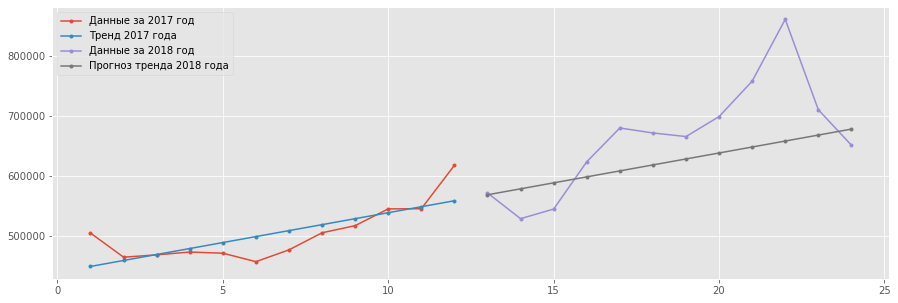

In [11]:
# Функция выделения кусков по годам
def filter_by_year_date(data_frame, year):
    start = dt.date(year, 1, 1)
    finish = dt.date(year, 12, 31)
    return (start <= data_frame.index) & (data_frame.index <= finish)

# Функция расчёта коэффициентов тренда по выбанному году
def calc_trend_by_year(dataframe: pd.DataFrame, year: int) -> tuple:
    x = np.arange(1, 13, 1).reshape(-1, 1)
    # Добавление константы для поиска уравнения в виде y = a x + b
    X = sm.add_constant(x)
    # Кусок данных, для которого строится тренд
    y = dataframe[filter_by_year_date(dataframe, year)].values.astype(float)

    # Метод наименьших квадратов
    model = sm.OLS(y, X)
    results = model.fit()

    return results.params

b, a = calc_trend_by_year(ural_mineral, 2017)
x = np.arange(1, 13, 1).reshape(-1, 1)
# Демонстрация решения
plt.plot(x, ural_mineral[filter_by_year_date(ural_mineral, 2017)].values.astype(float), '.-', label='Данные за 2017 год')
plt.plot(x, b + a * x, '.-', label='Тренд 2017 года')
plt.plot(x + 12, ural_mineral[filter_by_year_date(ural_mineral, 2018)].values.astype(float), '.-', label='Данные за 2018 год')
plt.plot(x + 12, b + a * (x + 12), '.-', label='Прогноз тренда 2018 года')
plt.legend()

#### Расчёт трендов

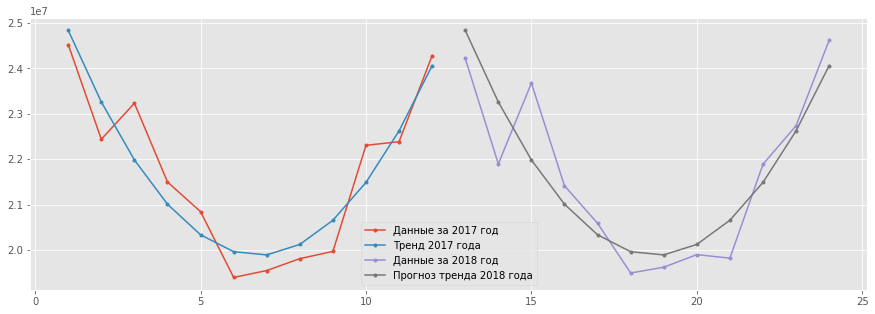

In [12]:
# Расчёт коэффициентов
b_m, a_m = calc_trend_by_year(ural_mineral, 2017)
b_p, a_p = calc_trend_by_year(ural_process, 2017)
b_u, a_u = calc_trend_by_year(ural_utilites, 2017)

# Расчёт коэффициентов для тренда потребления электроэнергии
x = np.arange(1, 13, 1).reshape(-1, 1)
v1 = lambda xx: a_m * xx + b_m
v2 = lambda xx: a_p * xx + b_p
v3 = lambda xx: a_u * xx + b_u

X = np.hstack([v1(x), v1(x)**2, v2(x), v2(x)**2, v3(x), v3(x)**2])
X = sm.add_constant(X)
# Кусок данных потребления электроэнергии
y_2017 = df_trend_month[filter_by_year_date(df_trend_month, 2017)].values.astype(float)
y_2018 = df_trend_month[filter_by_year_date(df_trend_month, 2018)].values.astype(float)

# Метод наименьших квадратов
model = sm.OLS(y_2017, X)
results = model.fit()
a0, a1, a2, a3, a4, a5, a6 = results.params

# Вывод решения
plt.plot(x, y_2017, '.-', label='Данные за 2017 год')
plt.plot(x, a0 + a1 * v1(x) + a2 * v1(x)**2 + a3 * v2(x) + a4 * v2(x)**2 + a5 * v3(x) + a6 * v3(x)**2, '.-', label='Тренд 2017 года')
plt.plot(x + 12, y_2018, '.-', label='Данные за 2018 год')
plt.plot(x + 12, a0 + a1 * v1(x) + a2 * v1(x)**2 + a3 * v2(x) + a4 * v2(x)**2 + a5 * v3(x) + a6 * v3(x)**2, '.-', label='Прогноз тренда 2018 года')
plt.legend()

### 6. Моделирование остатка

In [13]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        plt.tight_layout()
    return

# Функция выделения кусков по годам
def filter_by_year_time_date(data_frame, year):
    start = dt.datetime(year, 1, 1, 0, 0)
    finish = dt.datetime(year, 12, 31, 23, 59)
    return (start <= data_frame.index) & (data_frame.index <= finish)

# Вырезаются данные за 2017 и 2018 годы
df_noise_2017 = df_noise[filter_by_year_time_date(df_noise, 2017)]
df_noise_2018 = df_noise[filter_by_year_time_date(df_noise, 2018)]

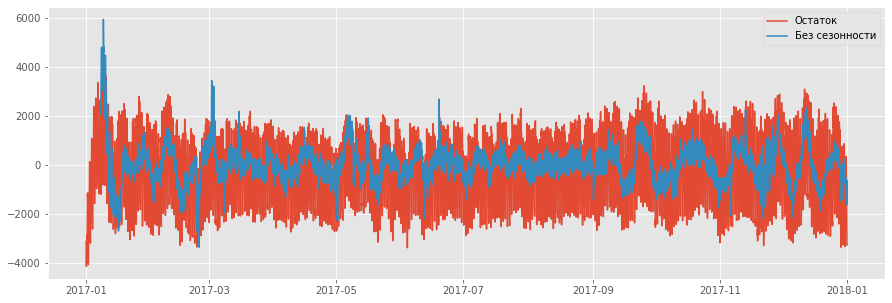

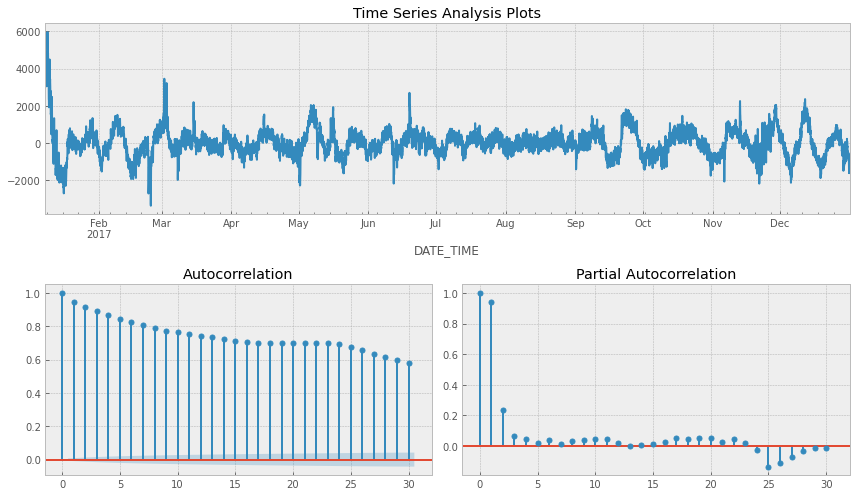

In [14]:
# В данных есть сезонность, попытаемся её удалить
df_noise_2017['SHIFTED'] = df_noise_2017['E_USE_FACT'] - df_noise_2017['E_USE_FACT'].shift(24 * 7)
# Вывод графиков
plt.plot(df_noise_2017['E_USE_FACT'], label='Остаток')
plt.plot(df_noise_2017['SHIFTED'], label='Без сезонности')
plt.legend()
# Статистика
tsplot(df_noise_2017['SHIFTED'][~np.isnan(df_noise_2017['SHIFTED'])], lags=30)

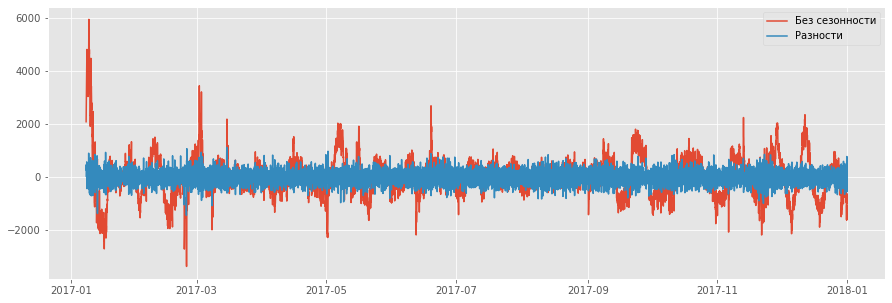

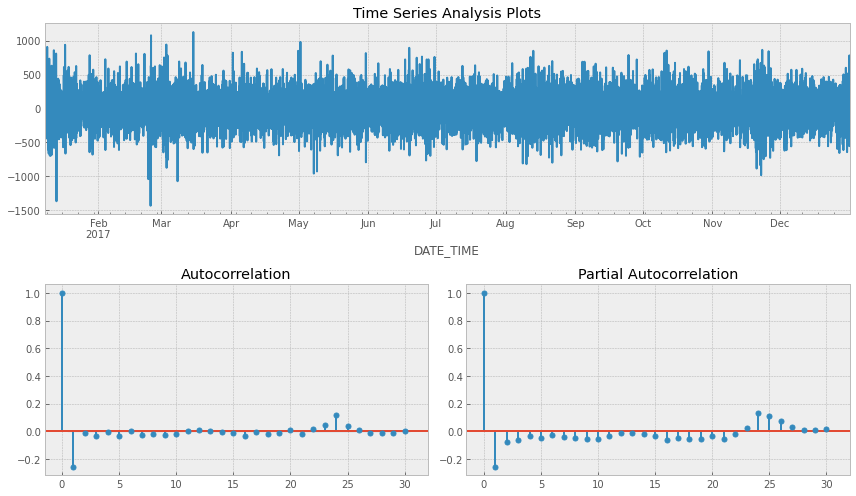

In [15]:
# Рассмотрим разницы
df_noise_2017['DIFF'] = df_noise_2017['SHIFTED'] - df_noise_2017['SHIFTED'].shift(1)
# Вывод графиков
plt.plot(df_noise_2017['SHIFTED'], label='Без сезонности')
plt.plot(df_noise_2017['DIFF'], label='Разности')
plt.legend()
# Статистика
tsplot(df_noise_2017['DIFF'][~np.isnan(df_noise_2017['DIFF'])], lags=30)

In [16]:
# Подбор параметров модели
ps = range(0, 1)
d=1
qs = range(0, 1)
Ps = range(0, 1)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df_noise_2017['E_USE_FACT'][-200:], rder=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24*7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\WPy64-3850\python-3.8.5.amd64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\WPy64-3850\python-3.8.5.amd64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.07s/it]

     parameters         aic
0  (0, 0, 0, 0)  462.274303


C:\WPy64-3850\python-3.8.5.amd64\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-17-142f7ce5ea73>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noise_2017['arima_model'] = best_model.fittedvalues


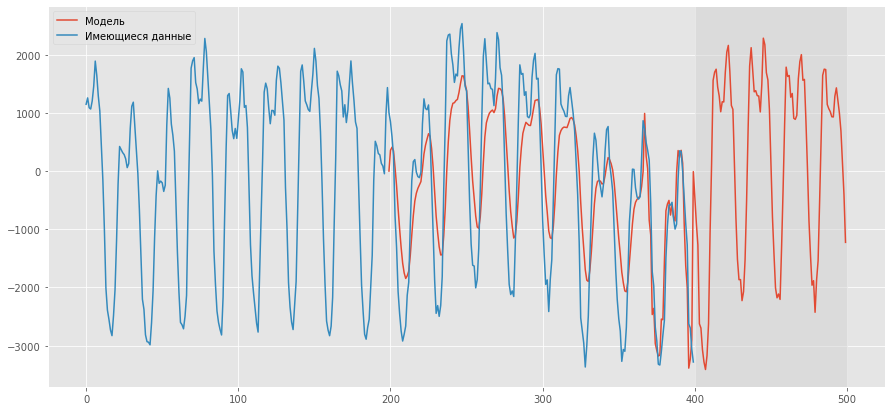

In [17]:
# Демонстрация решения
df_noise_2017['arima_model'] = best_model.fittedvalues
forecast = best_model.predict(start = df_noise_2017.shape[0], end = df_noise_2017.shape[0] + 100)
forecast = df_noise_2017.arima_model.append(forecast).values[-500:]
actual = df_noise_2017.E_USE_FACT.values[-400:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, label="Модель")
plt.plot(actual, label="Имеющиеся данные")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

C:\WPy64-3850\python-3.8.5.amd64\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


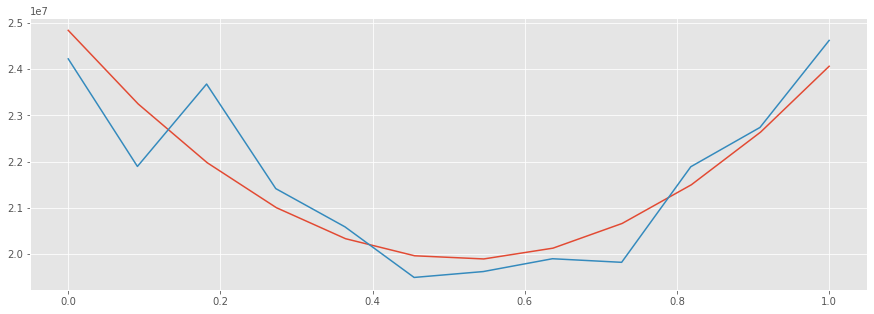

In [33]:
from scipy.interpolate import interp1d
# Проверка прогноза
trend_2018 = a0 + a1 * v1(x) + a2 * v1(x)**2 + a3 * v2(x) + a4 * v2(x)**2 + a5 * v3(x) + a6 * v3(x)**2
trend_2018 = trend_2018.ravel()

xx0 = np.linspace(0, 1, len(trend_2018))
xx1 = np.linspace(0, 1, len(df_noise_2018))
xx2 = np.linspace(0, 1, len(y_2018))
# Фукнция интерполяции
trend = interp1d(xx0, trend_2018)

plt.plot(xx1, trend(xx1).T)
plt.plot(xx2, y_2018)